In [1]:
from pyspark.sql import SparkSession

# .master("local[4]") \
spark = SparkSession.builder \
    .appName("works_text_analysis_flattened") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "1024") \
    .config("spark.sql.orc.columnarReaderBatchSize", "1024") \
    .config("spark.sql.shuffle.partitions", "128") \
    .config("spark.default.parallelism", "128") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/01 11:02:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Word Count Analysis for Works Catalog (Flattened Data)

This notebook performs comprehensive text analysis using only the concatenated text from `spark.table("works_text_flattened").withColumn("all_text", concat_ws(" ", *[col(c) for c in text_columns]))`. This approach treats all text fields as a single unified text for analysis.

In [2]:
from pyspark.sql.functions import col, split, explode, count, concat_ws

# Define the list of text columns to include in the word count
text_columns = [
    "title",
    "description",
    "physicalDescription",
    "lettering",
    "referenceNumber",
    "edition",
    "contributor_names",
    "alternative_titles",
    "subject_labels",
    "genre_labels",
    "language_labels",
    "production_info",
    "note_contents"
]

# Load the works_text_flattened table and select text columns
df = spark.table("works_text_flattened").selectExpr("id", *[f"CAST({c} AS STRING) as {c}" for c in text_columns])

# Create a single column with all text concatenated, separated by spaces
# This handles potential nulls by coalescing them to empty strings before concatenation
df_combined_text = df.withColumn("all_text", concat_ws(" ", *[col(c) for c in text_columns]))

# Split the 'all_text' column into an array of words, then explode the array to get one word per row
word_df = df_combined_text.select(explode(split(col("all_text"), '\\s+')).alias("word"))

# Filter out empty strings that might result from multiple spaces or empty initial columns
word_df_filtered = word_df.filter(col("word") != "")

# Count the total number of words
total_word_count = word_df_filtered.count()

print(f"Total word count across specified text columns: {total_word_count}")

# Show some of the words and their counts for verification (optional)
# word_df_filtered.groupBy("word").count().orderBy("count", ascending=False).show()

Total word count across specified text columns: 79955024


# Text Analysis of Works Collection (Unified Text Approach)

In this section, we'll analyze the unified text created by concatenating all text fields from the `works_text_flattened` table. We'll perform:

1. Basic text statistics (length, word count, etc.) on the combined text
2. Visualize distribution of combined text length
3. Apply text analysis techniques like term frequency, n-grams, and sentiment analysis
4. Topic modeling on the unified text 
5. Apply novel text characterization methods
6. Named entity recognition and temporal analysis

In [3]:
# Import necessary libraries for text analysis and visualization
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Configure matplotlib for better display
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [4]:
# Cache the combined text data for faster processing
df_combined_text.cache()

# Print schema to verify structure
df_combined_text.printSchema()

# Calculate text statistics for the combined all_text field
text_stats = df_combined_text.select(
    "id",
    # Calculate various metrics for combined text
    F.length("all_text").alias("all_text_length"),
    F.size(F.split("all_text", "\\s+")).alias("all_text_word_count"),
    
    # Calculate character count excluding spaces
    F.length(F.regexp_replace("all_text", "\\s", "")).alias("all_text_char_count"),
    
    # Calculate sentence count (approximate, based on periods, exclamation marks, question marks)
    F.size(F.split("all_text", "[.!?]+")).alias("all_text_sentence_count")
)

# Calculate summary statistics
summary_stats = text_stats.summary()
summary_stats.show()

# Show record count
print(f"Total number of records: {df_combined_text.count()}")
print(f"Records with non-empty text: {df_combined_text.filter(F.length('all_text') > 0).count()}")

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- physicalDescription: string (nullable = true)
 |-- lettering: string (nullable = true)
 |-- referenceNumber: string (nullable = true)
 |-- edition: string (nullable = true)
 |-- contributor_names: string (nullable = true)
 |-- alternative_titles: string (nullable = true)
 |-- subject_labels: string (nullable = true)
 |-- genre_labels: string (nullable = true)
 |-- language_labels: string (nullable = true)
 |-- production_info: string (nullable = true)
 |-- note_contents: string (nullable = true)
 |-- all_text: string (nullable = false)



+-------+--------+------------------+-------------------+-------------------+-----------------------+
|summary|      id|   all_text_length|all_text_word_count|all_text_char_count|all_text_sentence_count|
+-------+--------+------------------+-------------------+-------------------+-----------------------+
|  count| 1167444|           1167444|            1167444|            1167444|                1167444|
|   mean|    NULL|468.85126652755935|  68.84577418702739|  397.9397949708937|      8.068830710509454|
| stddev|    NULL| 605.7167220932569|  88.00341662590031|  515.6624631119257|     10.787067822696079|
|    min|a222zvge|                 7|                  2|                  0|                      1|
|    25%|    NULL|               260|                 38|                219|                      4|
|    50%|    NULL|               391|                 55|                336|                      7|
|    75%|    NULL|               553|                 85|                467|     

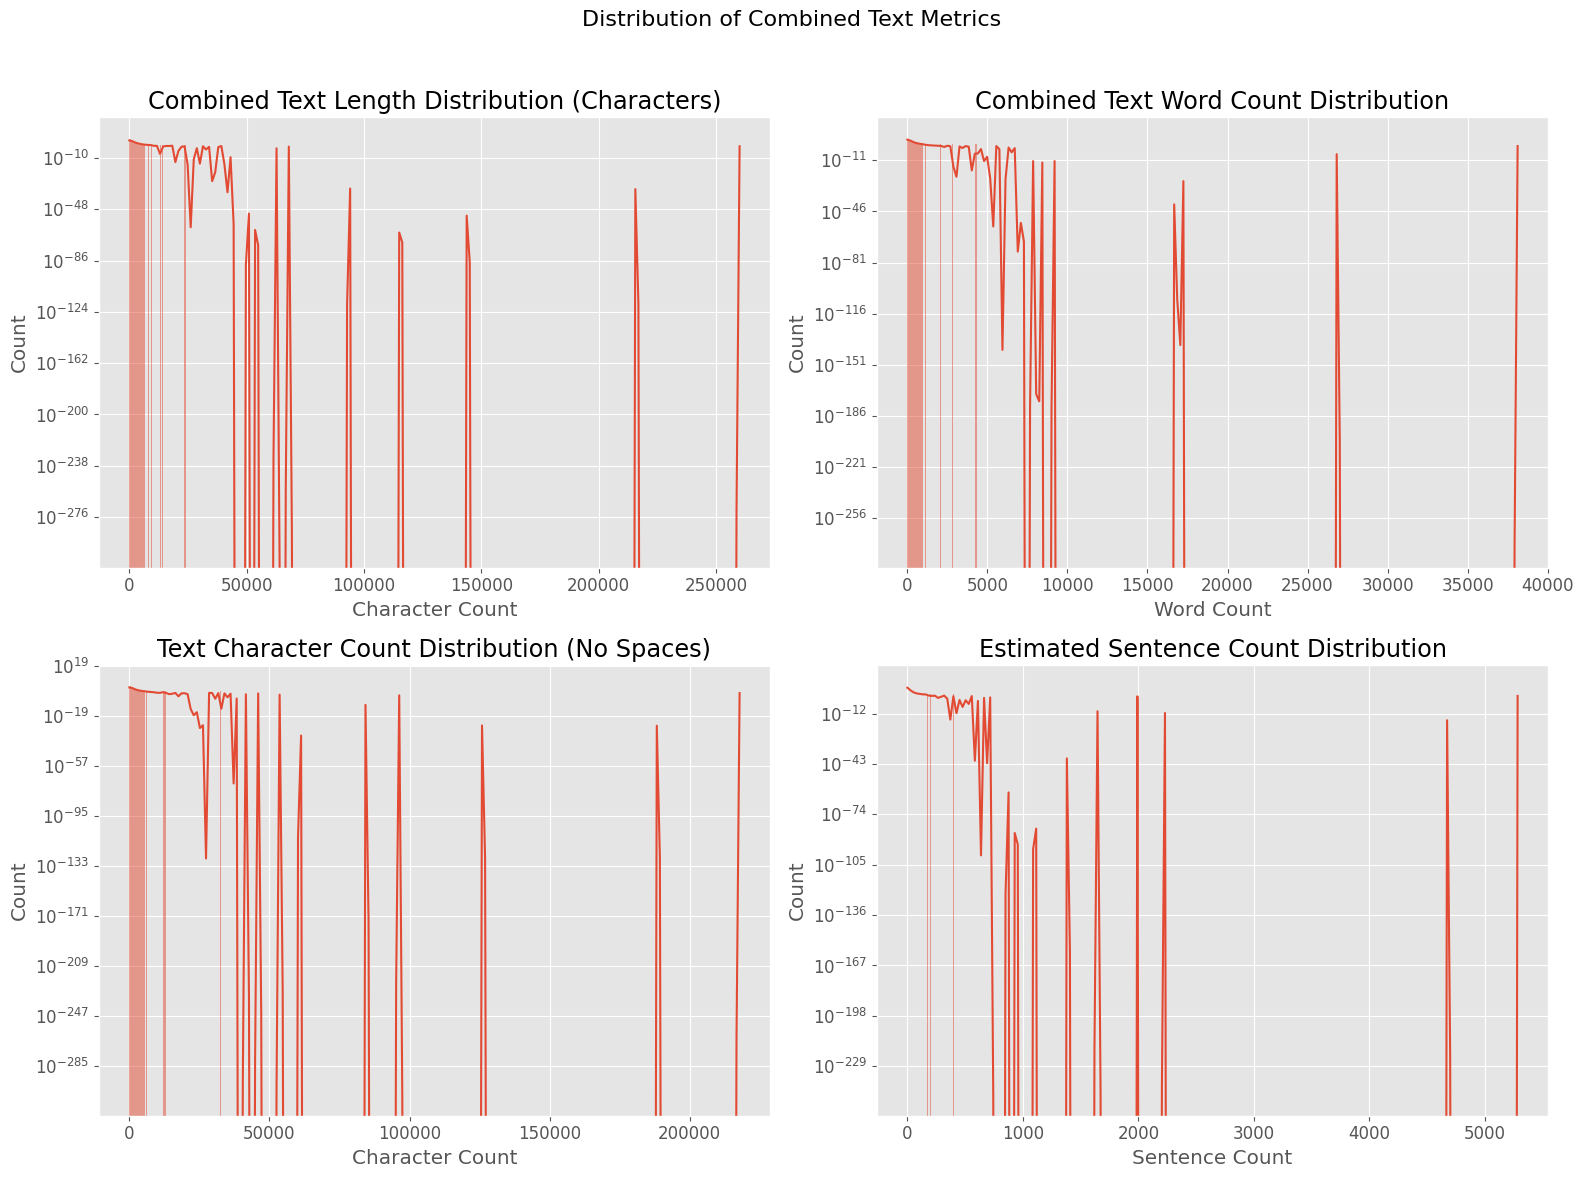

In [5]:
# Convert text statistics to pandas for visualization
text_stats_pd = text_stats.toPandas()

# Create visualizations for the combined text metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Combined Text Metrics', fontsize=16)

# Plot character length distribution
sns.histplot(text_stats_pd['all_text_length'].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Combined Text Length Distribution (Characters)')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_yscale('log')

# Plot word count distribution
sns.histplot(text_stats_pd['all_text_word_count'].dropna(), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Combined Text Word Count Distribution')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_yscale('log')

# Plot character count (no spaces) distribution
sns.histplot(text_stats_pd['all_text_char_count'].dropna(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Text Character Count Distribution (No Spaces)')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_yscale('log')

# Plot sentence count distribution
sns.histplot(text_stats_pd['all_text_sentence_count'].dropna(), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Estimated Sentence Count Distribution')
axes[1, 1].set_xlabel('Sentence Count')
axes[1, 1].set_yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Text Complexity Analysis on Combined Text

Let's analyze the complexity and readability of the combined text using metrics such as:
- Average word length
- Lexical diversity (ratio of unique words to total words)
- Presence of specialized vocabulary

+-------+--------+------------------------+--------------------------+
|summary|      id|all_text_avg_word_length|all_text_lexical_diversity|
+-------+--------+------------------------+--------------------------+
|  count| 1167444|                 1167354|                   1167354|
|   mean|    NULL|       5.945876704111398|        0.7825498317973626|
| stddev|    NULL|      0.7835928858232823|       0.17222860556883565|
|    min|a222zvge|                     2.0|                0.09821428|
|    25%|    NULL|               5.4166665|                 0.6966292|
|    50%|    NULL|               5.8405795|                0.83076924|
|    75%|    NULL|               6.4102564|                0.90909094|
|    max|zzzyvsgs|                26.62963|                       1.0|
+-------+--------+------------------------+--------------------------+



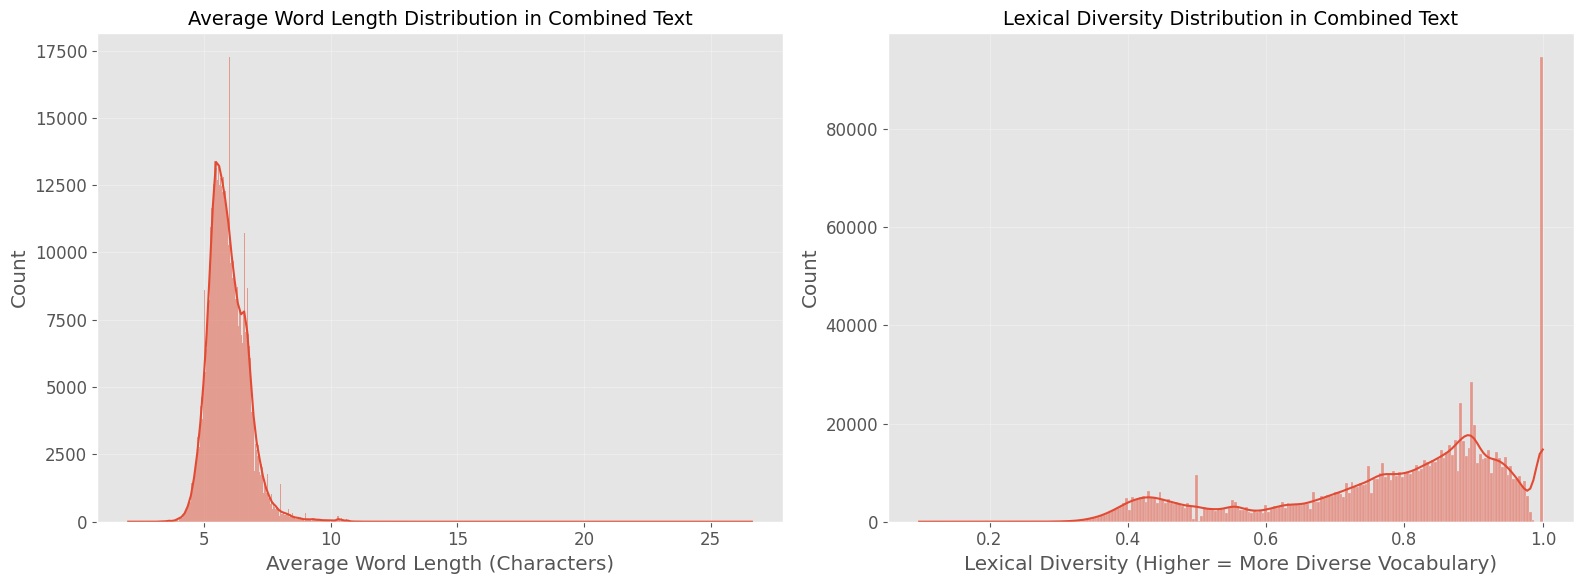

In [6]:
# Calculate text complexity metrics for the combined text
complexity_df = df_combined_text.select("id", "all_text")

# Define UDF for calculating average word length
@F.udf(returnType=FloatType())
def avg_word_length(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return sum(len(word) for word in words) / len(words)

# Define UDF for calculating lexical diversity (unique words / total words)
@F.udf(returnType=FloatType())
def lexical_diversity(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w.lower() for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return len(set(words)) / len(words)

# Apply the UDFs to calculate complexity metrics
complexity_analysis = complexity_df.select(
    "id",
    avg_word_length("all_text").alias("all_text_avg_word_length"),
    lexical_diversity("all_text").alias("all_text_lexical_diversity")
)

# Show summary of complexity metrics
complexity_analysis.summary().show()

# Convert to pandas for visualization
complexity_pd = complexity_analysis.toPandas()

# Create visualizations for complexity metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot average word length distribution
sns.histplot(complexity_pd['all_text_avg_word_length'].dropna(), kde=True, ax=axes[0])
axes[0].set_title('Average Word Length Distribution in Combined Text', fontsize=14)
axes[0].set_xlabel('Average Word Length (Characters)')
axes[0].grid(True, alpha=0.3)

# Plot lexical diversity distribution
sns.histplot(complexity_pd['all_text_lexical_diversity'].dropna(), kde=True, ax=axes[1])
axes[1].set_title('Lexical Diversity Distribution in Combined Text', fontsize=14)
axes[1].set_xlabel('Lexical Diversity (Higher = More Diverse Vocabulary)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Term Frequency Analysis on Combined Text

Let's explore the most common words and phrases in the combined text to understand the content better.

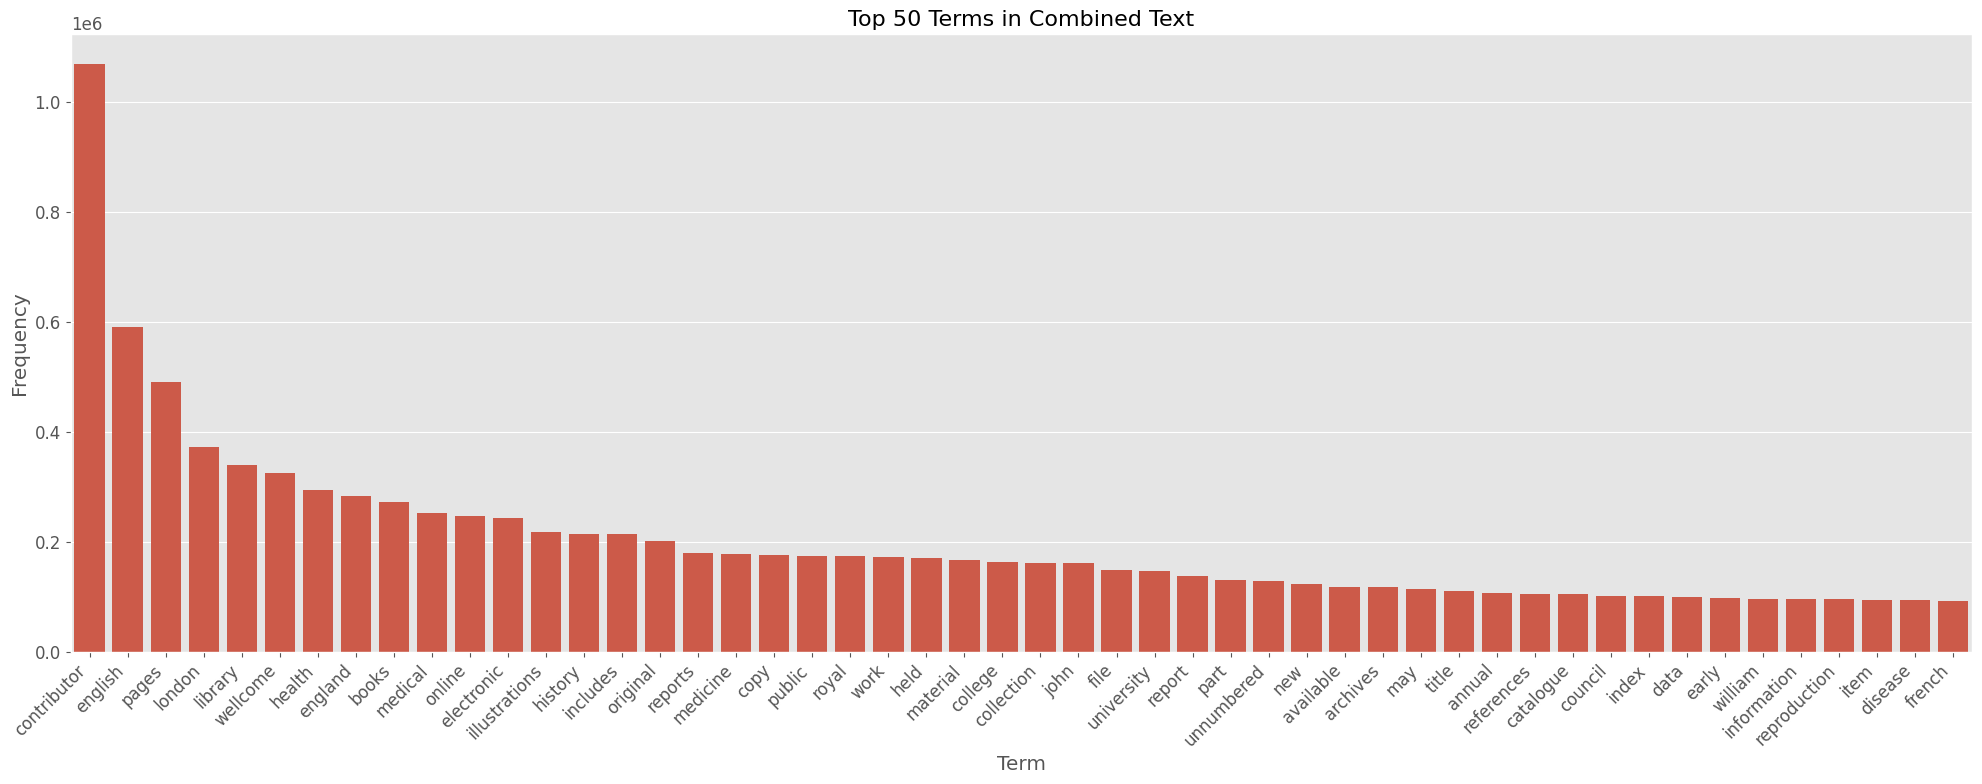

In [7]:
# Term frequency analysis for the combined text
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StopWordsRemover
from pyspark.sql.functions import explode, col

# Select non-empty combined text
combined_text_df = df_combined_text.filter(F.length("all_text") > 0).select("id", "all_text")

# 1) Split on non-word chars (keeps only letters & numbers)
regex_tokenizer = RegexTokenizer(
    inputCol="all_text",
    outputCol="words",
    pattern="\\W+",        # splits on anything other than [A-Za-z0-9_]
    minTokenLength=2       # drop 1-letter "words"
)

words_df = regex_tokenizer.transform(combined_text_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(words_df)

# Create a custom UDF to filter out numbers and short tokens
@F.udf(returnType=ArrayType(StringType()))
def clean_tokens(tokens):
    if not tokens:
        return []
    return [token.lower() for token in tokens if len(token) > 2 and not token.isdigit()]

cleaned_df = filtered_df.withColumn("clean_words", clean_tokens(col("filtered_words")))

# Calculate term frequencies
cv = CountVectorizer(inputCol="clean_words", outputCol="term_freq", minDF=5, vocabSize=10000)
cv_model = cv.fit(cleaned_df)
term_freq_df = cv_model.transform(cleaned_df)

# Extract vocabulary from the CountVectorizerModel
vocab = cv_model.vocabulary

def extract_term_counts_fn(vocab_list):
    @F.udf(returnType=ArrayType(StructType([
        StructField("term", StringType()),
        StructField("count", IntegerType())
    ])))
    def extract(vector):
        indices = vector.indices.tolist()
        values = vector.values.tolist()
        return [(vocab_list[idx], int(val))
                for idx, val in zip(indices, values)]
    return extract

# Apply it using closure:
term_counts_df = term_freq_df.withColumn(
    "term_counts",
    extract_term_counts_fn(vocab)(col("term_freq"))
)

# Explode the array to get individual term-count pairs
exploded_df = term_counts_df.select(
    "id",
    explode("term_counts").alias("term_count")
)

# Extract term and count from the struct
term_count_df = exploded_df.select(
    "id", 
    col("term_count.term").alias("term"),
    col("term_count.count").alias("count")
)

# Group by term and sum counts
term_totals = term_count_df.groupBy("term").agg(F.sum("count").alias("total_count"))

top_terms = term_totals.orderBy(col("total_count").desc()).limit(50)
top_terms_pd = top_terms.toPandas()

# Plot top terms
plt.figure(figsize=(20, 8))
sns.barplot(x="term", y="total_count", data=top_terms_pd)
plt.title('Top 50 Terms in Combined Text', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

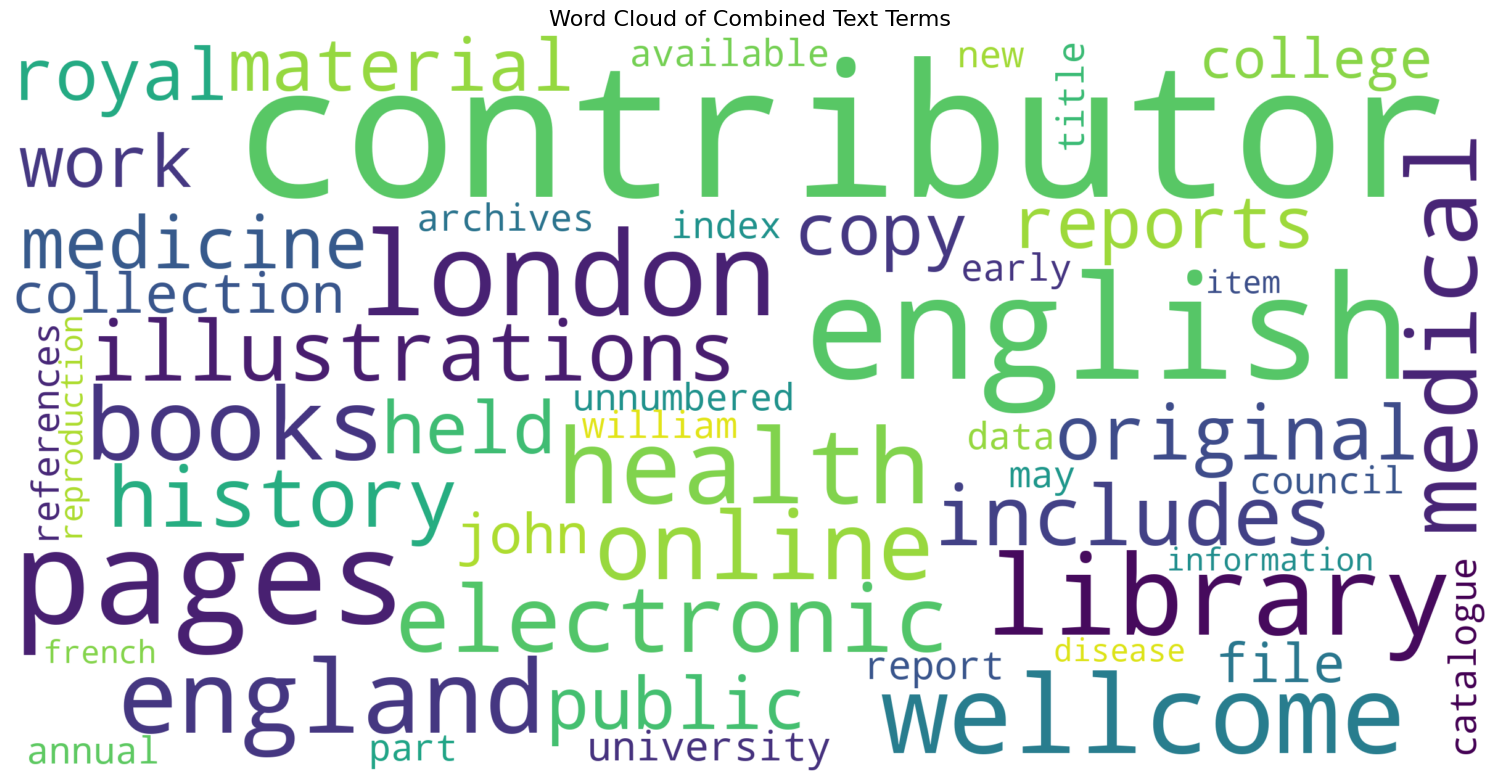

In [8]:
# Generate a word cloud visualization for the combined text
try:
    from wordcloud import WordCloud
    
    # Create a dictionary from the top terms dataframe
    word_freq = dict(zip(top_terms_pd['term'], top_terms_pd['total_count']))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', max_words=100,
        max_font_size=100, scale=3, random_state=42).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Combined Text Terms', fontsize=16)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("WordCloud package not available. Install using: pip install wordcloud")

## N-gram Analysis on Combined Text

Let's analyze common phrases (bigrams and trigrams) to identify multi-word expressions and common patterns in the combined text.

In [ ]:
# N-gram analysis to identify common phrases in combined text
from pyspark.ml.feature import NGram

# Add bigrams (2-word phrases)
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
bigram_df = bigram.transform(filtered_df)

# Add trigrams (3-word phrases)
trigram = NGram(n=3, inputCol="filtered_words", outputCol="trigrams")
ngram_df = trigram.transform(bigram_df)

# Function to get top n-grams


def get_top_ngrams(df, ngram_col, n=40):
    # Explode the n-grams to get individual entries
    exploded_df = df.select(explode(col(ngram_col)).alias("ngram"))

    # Count the occurrences of each n-gram
    ngram_counts = exploded_df.groupBy(
        "ngram").count().orderBy(col("count").desc())

    # Get top n n-grams
    return ngram_counts.limit(n).toPandas()


# Get top bigrams
top_bigrams = get_top_ngrams(ngram_df, "bigrams")

# Get top trigrams
top_trigrams = get_top_ngrams(ngram_df, "trigrams")

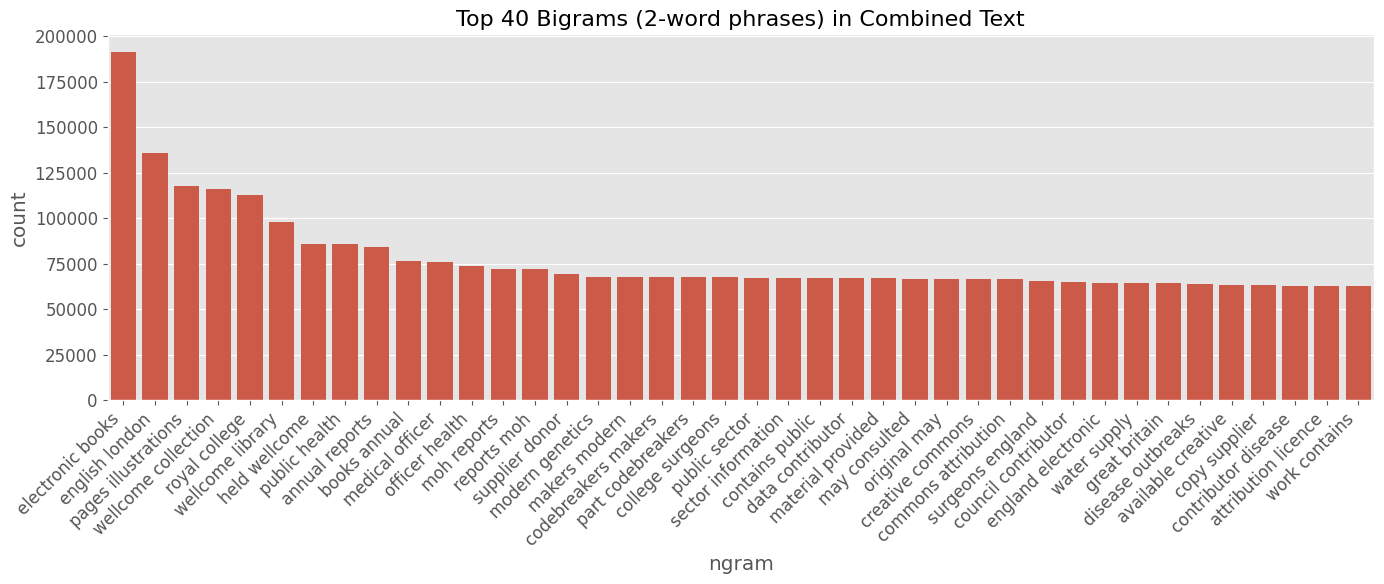

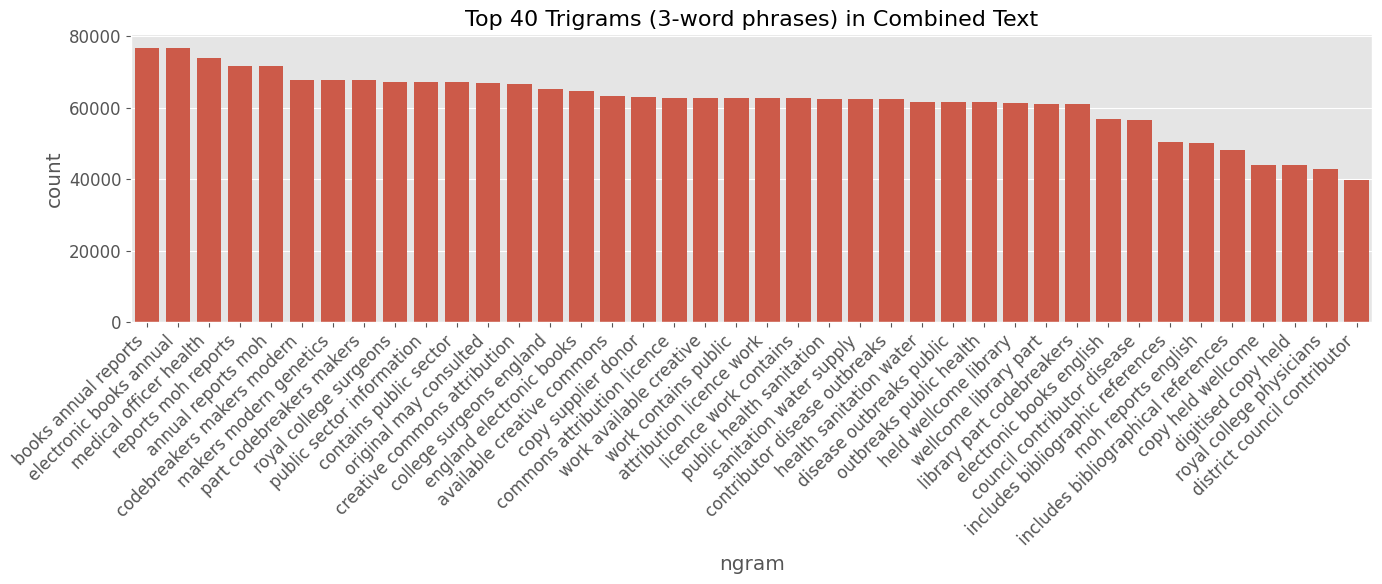

In [19]:
# Plot top bigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=top_bigrams.head(40))
plt.title('Top 40 Bigrams (2-word phrases) in Combined Text', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top trigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=top_trigrams.head(40))
plt.title('Top 40 Trigrams (3-word phrases) in Combined Text', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Topic Modeling on Combined Text

Let's use Latent Dirichlet Allocation (LDA) to discover abstract topics in the combined text from the collection.

### LDA Overview

LDA assumes each document is a mixture of topics, and each topic is a mixture of words. By fitting this hierarchical model to your combined text data, we can uncover interpretable themes and how they're distributed across documents.

In [10]:
# Topic modeling using LDA (Latent Dirichlet Allocation)
from pyspark.ml.clustering import LDA

# Prepare the data for LDA - using the term frequency data from previous cell
# Filter out documents with empty word lists to avoid errors
lda_input = term_freq_df.filter(F.size("clean_words") > 0)

# Number of topics to extract
num_topics = 10

# Create an LDA model
lda = LDA(k=num_topics, maxIter=10, featuresCol="term_freq")
lda_model = lda.fit(lda_input)

# Get topics and their terms
topics = lda_model.describeTopics()
topics.show(truncate=False)

# Convert topics to a more interpretable format
@F.udf(returnType=ArrayType(StringType()))
def map_term_indices_to_words(termIndices, vocabulary):
    return [vocabulary[idx] for idx in termIndices]

# Apply UDF to get terms for each topic
topics_with_terms = topics.withColumn(
    "terms", 
    map_term_indices_to_words(
        col("termIndices"), 
        F.array([F.lit(word) for word in vocab])
    )
)

# Show topics with their terms
topics_with_terms.select("topic", "terms", "termWeights").show(truncate=100)

+-----+----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                   |termWeights                                                                                                                                                                                                                  |
+-----+----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[5, 39, 123, 0, 17, 1, 3, 4, 172, 13]         |[0.017412125194828022, 0.01325137441621729, 0.010422508305884615, 0.008234601052919082, 0.008109392347253875, 0.007

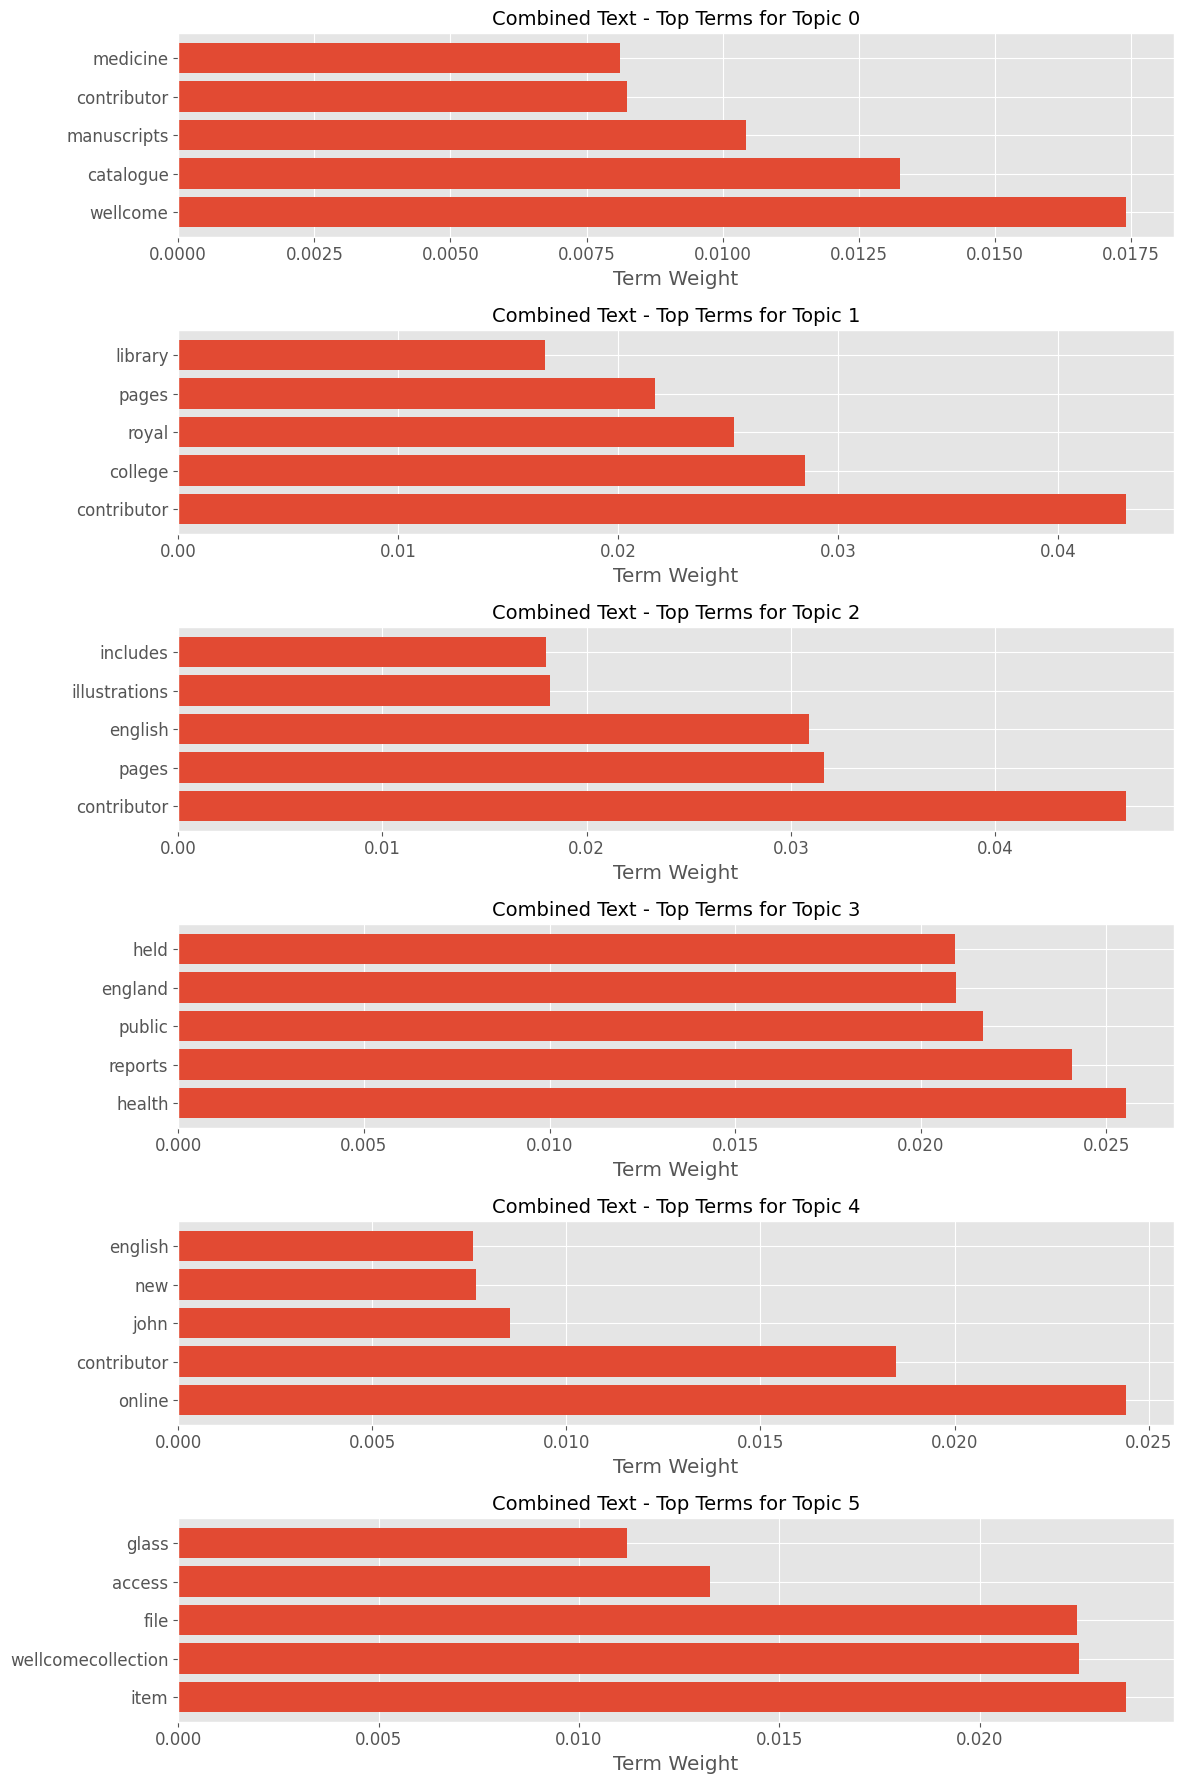

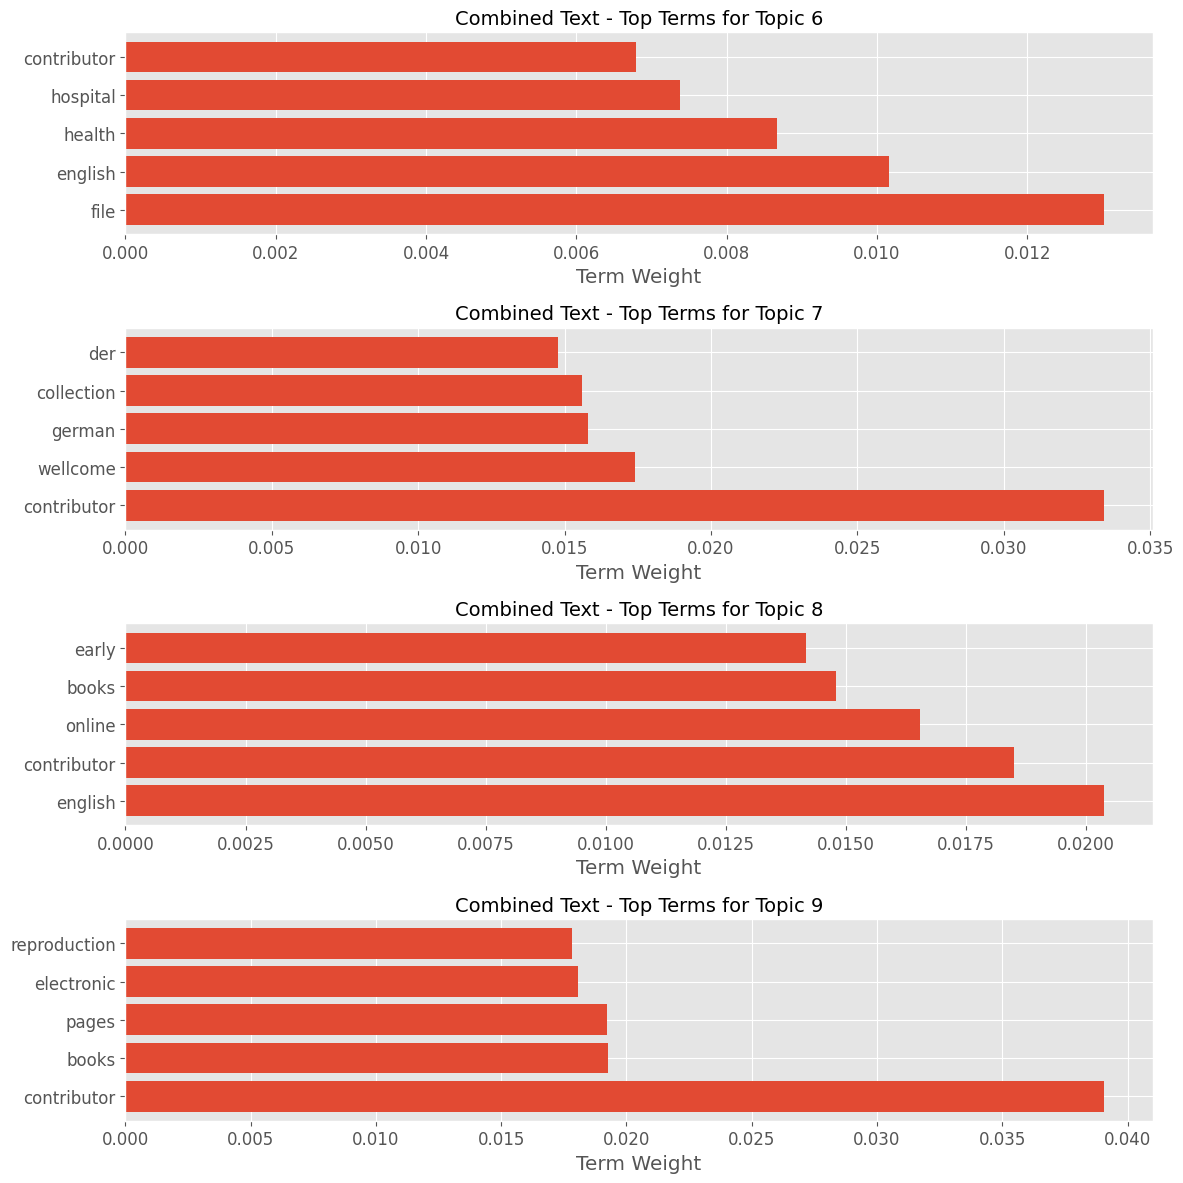

In [11]:
# Visualize topics and their most important terms
topics_df = topics_with_terms.toPandas()

# Create a function to plot top terms for each topic
def plot_topics(topics_df, field_name, num_terms=5):
    topics_to_plot = min(6, len(topics_df))  # Plot at most 6 topics at a time
    fig, axes = plt.subplots(topics_to_plot, 1, figsize=(12, 3*topics_to_plot))
    
    if topics_to_plot == 1:
        axes = [axes]  # Make sure axes is always a list
        
    for i, (ax, (_, row)) in enumerate(zip(axes, topics_df.iterrows())):
        # Get top terms and their weights
        terms = row['terms'][:num_terms]
        weights = row['termWeights'][:num_terms]
        
        # Create horizontal bar chart
        ax.barh(range(len(terms)), weights, align='center')
        ax.set_yticks(range(len(terms)))
        ax.set_yticklabels(terms)
        ax.set_title(f'{field_name} - Top Terms for Topic {row["topic"]}', fontsize=14)
        ax.set_xlabel('Term Weight')
    
    plt.tight_layout()
    plt.show()

# Plot the top topics
plot_topics(topics_df, "Combined Text")

# If there are more than 6 topics, plot the rest
if len(topics_df) > 6:
    plot_topics(topics_df.iloc[6:], "Combined Text")

## Sentiment Analysis on Combined Text

Let's analyze the sentiment and subjectivity of the combined text to understand the emotional tone and perspective across the collection.

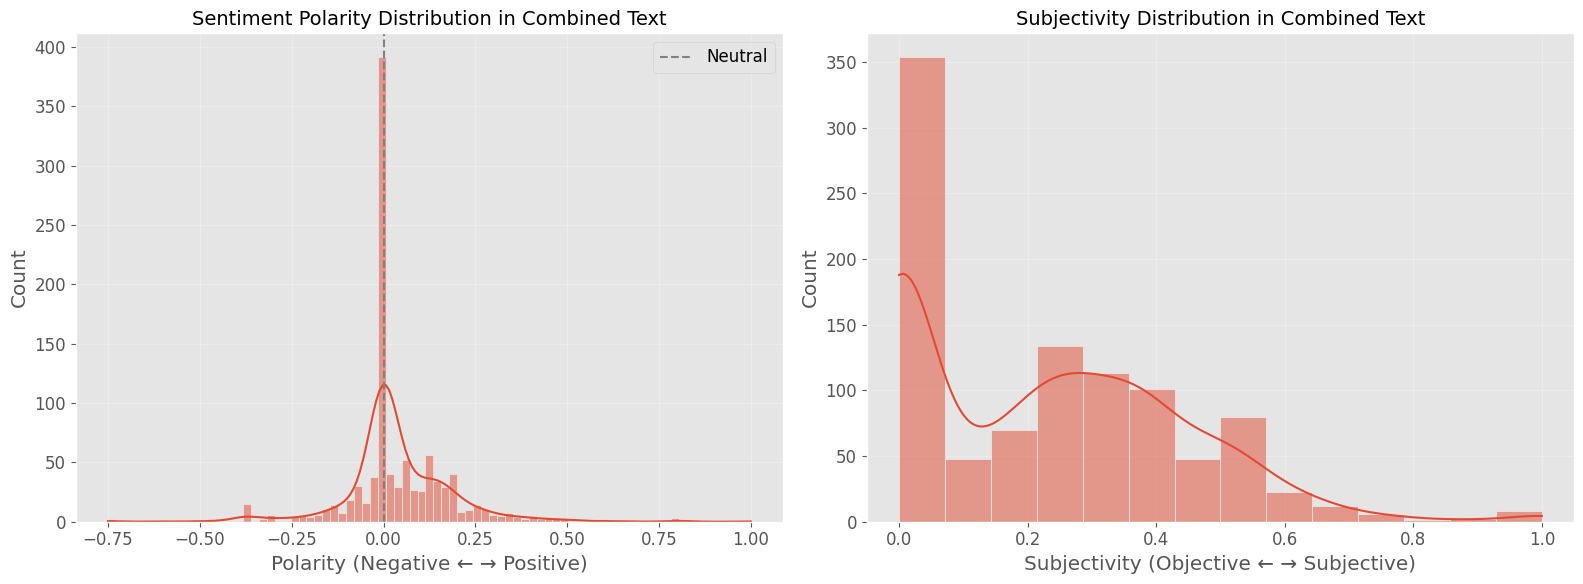

Sentiment Analysis Summary:
Mean Polarity: 0.039
Mean Subjectivity: 0.227
Polarity Range: -0.750 to 1.000
Subjectivity Range: 0.000 to 1.000


In [12]:
# Sentiment Analysis - Exploring emotional tone of combined text
try:
    from textblob import TextBlob
    import pandas as pd
    import numpy as np
    
    # Function to calculate sentiment polarity and subjectivity
    def get_sentiment(text):
        if pd.isna(text) or text.strip() == '':
            return (np.nan, np.nan)  # Return NaN for empty text
        blob = TextBlob(text)
        return (blob.sentiment.polarity, blob.sentiment.subjectivity)
    
    # Sample some combined text for sentiment analysis (for performance reasons)
    sample_data = df_combined_text.select('id', 'all_text').limit(1000).toPandas()
    
    # Calculate sentiment scores for combined text
    sentiment_data = []
    for _, row in sample_data.iterrows():
        if pd.notna(row['all_text']) and row['all_text'].strip():
            polarity, subjectivity = get_sentiment(row['all_text'])
            sentiment_data.append({
                'id': row['id'],
                'all_text_polarity': polarity,
                'all_text_subjectivity': subjectivity
            })
    
    # Create DataFrame with sentiment scores
    sentiment_df = pd.DataFrame(sentiment_data)
    
    # Create visualizations for sentiment analysis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot sentiment polarity distribution
    sns.histplot(sentiment_df['all_text_polarity'].dropna(), kde=True, ax=axes[0])
    axes[0].set_title('Sentiment Polarity Distribution in Combined Text', fontsize=14)
    axes[0].set_xlabel('Polarity (Negative ← → Positive)')
    axes[0].axvline(x=0, color='gray', linestyle='--', label='Neutral')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot subjectivity distribution
    sns.histplot(sentiment_df['all_text_subjectivity'].dropna(), kde=True, ax=axes[1])
    axes[1].set_title('Subjectivity Distribution in Combined Text', fontsize=14)
    axes[1].set_xlabel('Subjectivity (Objective ← → Subjective)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("Sentiment Analysis Summary:")
    print(f"Mean Polarity: {sentiment_df['all_text_polarity'].mean():.3f}")
    print(f"Mean Subjectivity: {sentiment_df['all_text_subjectivity'].mean():.3f}")
    print(f"Polarity Range: {sentiment_df['all_text_polarity'].min():.3f} to {sentiment_df['all_text_polarity'].max():.3f}")
    print(f"Subjectivity Range: {sentiment_df['all_text_subjectivity'].min():.3f} to {sentiment_df['all_text_subjectivity'].max():.3f}")
    
except ImportError:
    print("TextBlob not installed. Install with: pip install textblob")

## Text Readability Analysis

Let's analyze the readability and complexity of the combined text using the Flesch-Kincaid reading grade level and other readability metrics.

Readability Statistics Summary:


,flesch_reading_ease,flesch_kincaid_grade,smog_index,coleman_liau_index,automated_readability_index,dale_chall_readability_score,text_standard
count,108909.000000,108909.000000,108909.000000,108909.000000,108909.000000,108909.000000,108909.000000
mean,35.226931,11.554660,12.516013,14.765623,12.971123,14.701606,12.424125
std,19.993871,3.484764,2.711151,4.095138,4.391856,2.497496,3.352211
min,-104.068750,0.063500,3.129100,-4.678571,-2.563333,1.022333,1.000000
25%,22.723871,9.262587,10.793553,12.121429,10.105263,12.903523,11.000000
50%,35.575193,11.471524,12.161745,14.501449,12.525682,14.632933,12.000000
75%,49.017429,13.388696,13.968274,17.287805,15.141370,16.486306,14.000000
max,110.055000,29.957778,29.924255,73.483636,83.962839,23.617700,82.000000


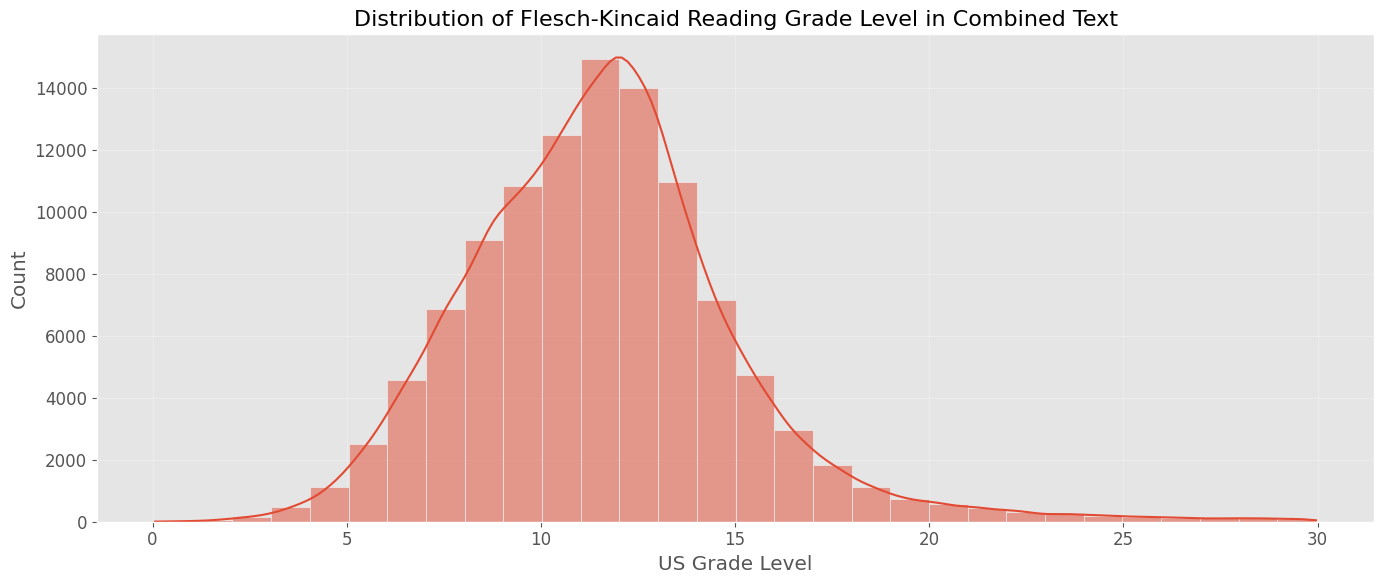


Average reading grade level: 11.6
This corresponds to approximately 12th grade level


In [13]:
# Text Readability and Complexity Metrics
try:
    import textstat
    
    # Sample data for readability analysis (subset for performance)
    readability_sample = df_combined_text.filter(F.length('all_text') > 100).select('id', 'all_text').sample(False, 0.1).toPandas()
    
    # Calculate readability scores
    readability_data = []
    for _, row in readability_sample.iterrows():
        if pd.notna(row['all_text']) and len(row['all_text'].strip()) > 0:
            text = row['all_text']
            try:
                readability_data.append({
                    'id': row['id'],
                    'flesch_reading_ease': textstat.flesch_reading_ease(text),
                    'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
                    'smog_index': textstat.smog_index(text),
                    'coleman_liau_index': textstat.coleman_liau_index(text),
                    'automated_readability_index': textstat.automated_readability_index(text),
                    'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
                    'text_standard': textstat.text_standard(text, float_output=True)
                })
            except Exception as e:
                # Skip texts that cause errors in readability calculation
                continue
    
    # Create DataFrame with readability metrics
    readability_df = pd.DataFrame(readability_data)

    # Remove extreme outliers for better visualization
    readability_df = readability_df[
        (readability_df['flesch_kincaid_grade'] >= 0) &
        (readability_df['flesch_kincaid_grade'] <= 30)
    ]
    
    # Calculate summary statistics
    readability_stats = readability_df.describe()
    print("Readability Statistics Summary:")
    display(readability_stats)
    
    # Plot distribution of reading level
    plt.figure(figsize=(14, 6))
    sns.histplot(readability_df['flesch_kincaid_grade'].dropna(), kde=True, bins=30)
    plt.title('Distribution of Flesch-Kincaid Reading Grade Level in Combined Text', fontsize=16)
    plt.xlabel('US Grade Level')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print readability summary
    mean_grade = readability_df['flesch_kincaid_grade'].mean()
    print(f"\nAverage reading grade level: {mean_grade:.1f}")
    print(f"This corresponds to approximately {mean_grade:.0f}th grade level")
    
except ImportError:
    print("TextStat not installed. Install with: pip install textstat")

## Named Entity Recognition on Combined Text

Let's extract named entities (people, places, organizations, dates, etc.) from the combined text to understand what kinds of entities are mentioned in the collection.

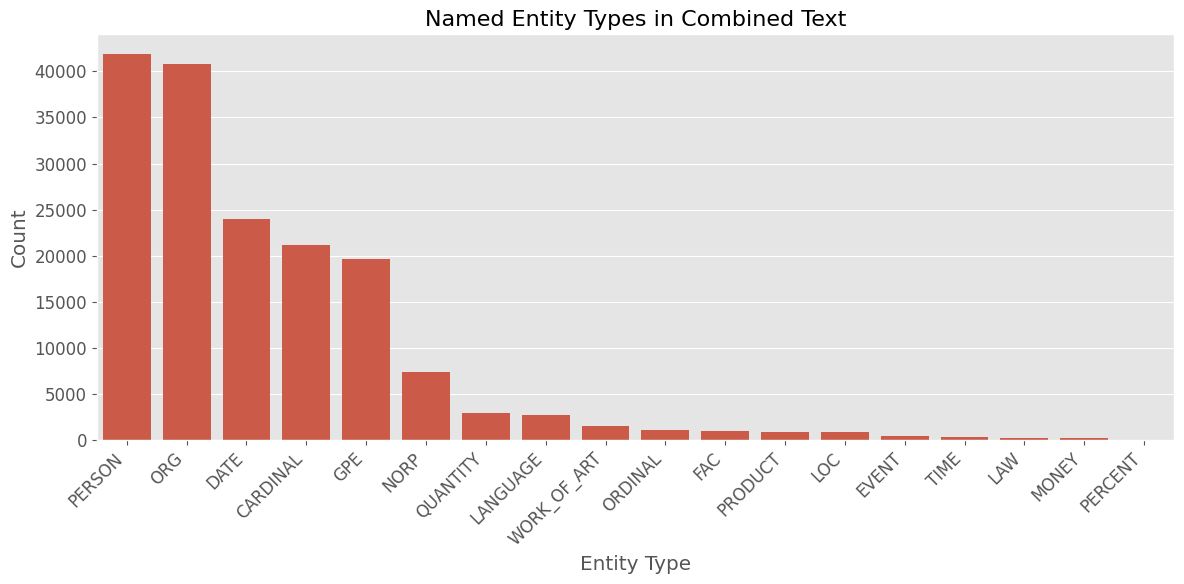


Most common entities by type:

ORG entities:
  - Archives: 711
  - MOH: 687
  - Codebreakers: 622
  - Modern Genetics: 621
  - Public Health: 612

DATE entities:
  - Annual: 867
  - 2014: 368
  - 1996: 131
  - the early 2000s: 127
  - 1998: 127

LANGUAGE entities:
  - English: 2455
  - French: 70
  - Latin: 59
  - Spanish: 23
  - Arabic: 23

CARDINAL entities:
  - 1: 3573
  - 2: 923
  - 3: 422
  - 4: 385
  - two: 361

WORK_OF_ART entities:
  - Bibliography: 109
  - Bibliography:: 33
  - Photographs English: 30
  - Bible: 29
  - Lithographs English: 22

PERSON entities:
  - John: 384
  - Watson: 259
  - William: 241
  - Brenner: 212
  - Thomas: 193

QUANTITY entities:
  - 24 cm: 316
  - 25 cm: 282
  - 21 cm: 196
  - 23 cm: 172
  - 22 cm: 160

NORP entities:
  - English: 2413
  - French: 737
  - German: 528
  - Italian: 219
  - Latin: 218

GPE entities:
  - London: 2514
  - England: 1391
  - UK: 507
  - Paris: 482
  - Cambridge: 454

PRODUCT entities:
  - Notes: 41
  - Includes: 27
  - 

In [18]:
# Named Entity Recognition using spaCy
try:
    import spacy
    from collections import Counter
    import pandas as pd
    
    # Load spaCy model
    try:
        nlp = spacy.load('en_core_web_lg')
        
        # Sample some combined text for NER (for performance reasons)
        sample_texts = df_combined_text.filter(F.length('all_text') > 50) \
                                      .select('all_text') \
                                      .sample(False, 0.01) \
                                      .toPandas()
        
        # Extract entities
        all_entities = []
        entity_texts = []
        entity_labels = []
        
        for text_row in sample_texts['all_text']:
            if pd.notna(text_row) and text_row.strip():
                # Limit text size for processing efficiency
                doc = nlp(text_row[:10000])  
                for ent in doc.ents:
                    all_entities.append((ent.text, ent.label_))
                    entity_texts.append(ent.text)
                    entity_labels.append(ent.label_)
        
        # Count entity types
        entity_type_counts = Counter([ent[1] for ent in all_entities])
        entity_counts_df = pd.DataFrame({
            'Entity Type': list(entity_type_counts.keys()),
            'Count': list(entity_type_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Create entity DataFrame
        entities_df = pd.DataFrame({
            'text': entity_texts,
            'label': entity_labels
        })
        
        # Plot entity type distribution
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Entity Type', y='Count', data=entity_counts_df)
        plt.title('Named Entity Types in Combined Text', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Show most common entities by type
        most_common_entities = {}
        for entity_type in entities_df['label'].unique():
            entities_of_type = entities_df[entities_df['label'] == entity_type]['text']
            most_common = Counter(entities_of_type).most_common(5)
            if most_common:
                most_common_entities[entity_type] = most_common
        
        print("\nMost common entities by type:")
        for entity_type, common_entities in most_common_entities.items():
            print(f"\n{entity_type} entities:")
            for entity, count in common_entities:
                print(f"  - {entity}: {count}")
    except Exception as e:
        print(f"Error loading spaCy model: {e}")
        print("Please install the English model with: python -m spacy download en_core_web_lg")
        
except ImportError:
    print("spaCy is not installed. Install using: pip install spacy")

## Text Clustering and Collection Segmentation

Let's segment the collection based on the combined text content to identify natural groupings using document embeddings.

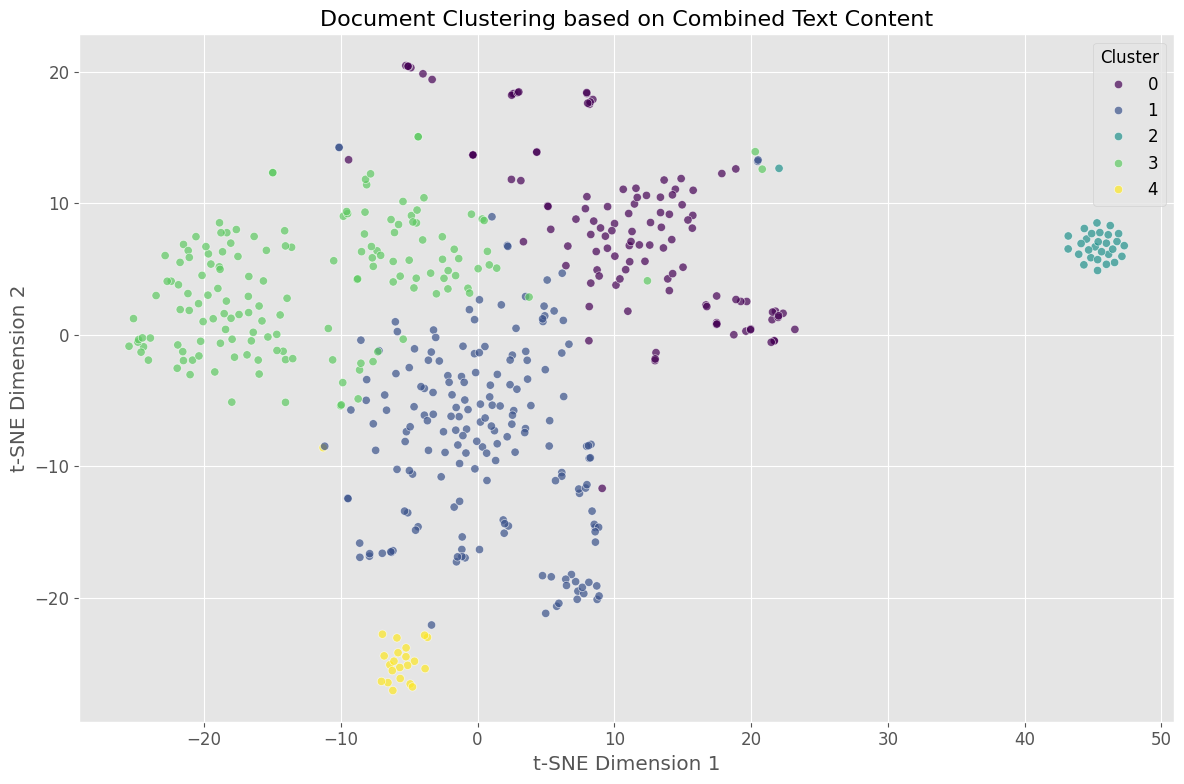

Documents per cluster:
  Cluster 0: 115 documents
  Cluster 1: 180 documents
  Cluster 2: 29 documents
  Cluster 3: 154 documents
  Cluster 4: 22 documents


In [15]:
# Text clustering using embeddings and dimensionality reduction
from pyspark.ml.feature import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Use the cleaned word lists from earlier
# Train Word2Vec model to get document embeddings
w2v = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="clean_words",
    outputCol="document_vector"
)

# Train the model and transform the data - only using documents with words
valid_docs = cleaned_df.filter(F.size("clean_words") > 0)
w2v_model = w2v.fit(valid_docs)
doc_vectors = w2v_model.transform(valid_docs)

# Convert to pandas for visualization (sample for performance)
doc_vectors_pd = doc_vectors.select("id", "document_vector").limit(500).toPandas()

# Convert vectors to numpy arrays for dimensionality reduction
vectors = np.array(doc_vectors_pd['document_vector'].tolist())

# Apply t-SNE for dimensionality reduction
if len(vectors) > 0:
    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    # Create visualization dataframe
    viz_df = pd.DataFrame({
        'id': doc_vectors_pd['id'],
        'x': vectors_2d[:, 0],
        'y': vectors_2d[:, 1],
        'cluster': clusters
    })
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x='x',
        y='y',
        data=viz_df,
        hue='cluster',
        palette='viridis',
        alpha=0.7)
    plt.title('Document Clustering based on Combined Text Content', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()
    
    # Print cluster statistics
    cluster_counts = pd.Series(clusters).value_counts().sort_index()
    print("Documents per cluster:")
    for cluster_id, count in cluster_counts.items():
        print(f"  Cluster {cluster_id}: {count} documents")
else:
    print("No valid document vectors found for clustering.")

## Temporal Pattern Analysis

Let's analyze if the combined text contains temporal references and patterns to understand historical contexts mentioned in the collection.

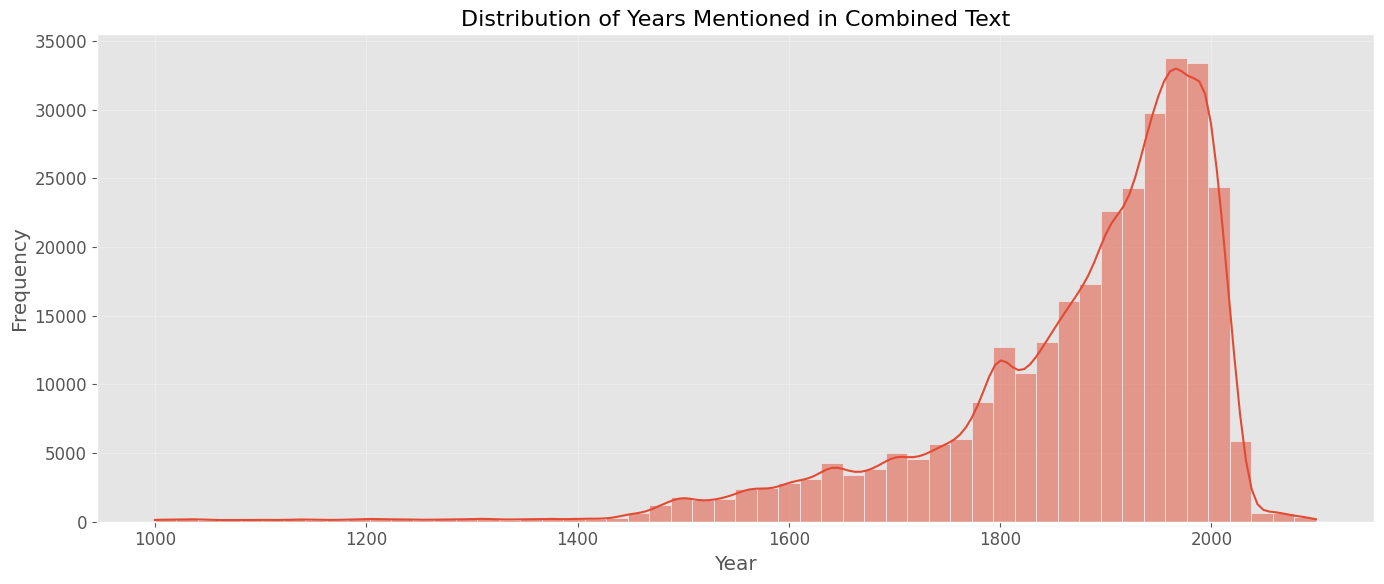

Most common years mentioned:
  - 2014: 3713
  - 2020: 2899
  - 1973: 2838
  - 1999: 2829
  - 1800: 2801
  - 1962: 2263
  - 1993: 1957
  - 1995: 1931
  - 1996: 1924
  - 1957: 1907

Most common centuries mentioned:
  - 20th century: 1785
  - 19th century: 1590
  - 18th century: 1331
  - 17th century: 701
  - 16th century: 438

Most common decades mentioned:
  - 2000s: 1377
  - 1970s: 516
  - 1980s: 430
  - 1950s: 419
  - 1960s: 355


In [16]:
# Extract and analyze temporal references in combined text
try:
    import re
    import pandas as pd
    from collections import Counter
    
    # Sample data for temporal analysis
    temporal_sample = df_combined_text.select('id', 'all_text').sample(False, 0.1).toPandas()
    
    # Regular expressions for finding years and centuries
    year_pattern = r'\b1[0-9]{3}\b|\b20[0-9]{2}\b'  # Years from 1000-2099
    century_pattern = r'\b(?:1[0-9]|20)th century\b|\b(?:1[0-9]|20)st century\b'  # 10th-21st century
    decade_pattern = r'\b(?:1[0-9]|20)[0-9]0s\b'  # 1000s-2090s decades
    
    # Function to extract temporal references
    def extract_temporal_refs(text):
        if pd.isna(text) or text.strip() == '':
            return [], [], []
            
        years = re.findall(year_pattern, text)
        centuries = re.findall(century_pattern, text)
        decades = re.findall(decade_pattern, text)
        
        return years, centuries, decades
    
    # Collect all temporal references
    all_years = []
    all_centuries = []
    all_decades = []
    
    # Process combined text
    for _, row in temporal_sample.iterrows():
        if pd.notna(row['all_text']) and row['all_text'].strip():
            years, centuries, decades = extract_temporal_refs(row['all_text'])
            all_years.extend(years)
            all_centuries.extend(centuries)
            all_decades.extend(decades)
    
    if all_years:
        # Convert years to integers for histogram
        year_ints = [int(y) for y in all_years if y.isdigit()]
        
        if year_ints:
            # Year range
            year_range = max(year_ints) - min(year_ints)
            
            # Plot distribution of years mentioned
            plt.figure(figsize=(14, 6))
            sns.histplot(year_ints, bins=max(20, int(year_range / 20)), kde=True)
            plt.title('Distribution of Years Mentioned in Combined Text', fontsize=16)
            plt.xlabel('Year')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # Show most common temporal references
    if all_years:
        print("Most common years mentioned:")
        for year, count in Counter(all_years).most_common(10):
            print(f"  - {year}: {count}")
    else:
        print("No years found in the sample")
        
    if all_centuries:
        print("\nMost common centuries mentioned:")
        for century, count in Counter(all_centuries).most_common(5):
            print(f"  - {century}: {count}")
    else:
        print("\nNo centuries found in the sample")
        
    if all_decades:
        print("\nMost common decades mentioned:")
        for decade, count in Counter(all_decades).most_common(5):
            print(f"  - {decade}: {count}")
    else:
        print("\nNo decades found in the sample")
        
except Exception as e:
    print(f"Error in temporal analysis: {e}")

## Conclusions and Insights

Based on our comprehensive text analysis of the combined text from the works collection, here are the key findings:

### 1. **Unified Text Analysis Approach**
By concatenating all text fields into a single `all_text` column, we've analyzed the collection as unified documents rather than separate field components. This approach provides:
- Overall content characterization across all metadata fields
- Comprehensive topic modeling that captures themes spanning multiple fields
- Holistic sentiment and readability analysis

### 2. **Text Statistics**
- **Combined text length distribution**: Shows the overall information density when all fields are combined
- **Word count patterns**: Reveals the vocabulary richness across the entire collection
- **Text complexity metrics**: Average word length and lexical diversity provide insights into the sophistication of the combined content

### 3. **Content Analysis**
- **Term frequency analysis**: Identified the most common terms across all combined text, showing dominant themes and concepts
- **N-gram analysis**: Revealed common phrases and multi-word expressions that characterize the collection
- **Topic modeling**: Discovered latent topics that emerge from the unified text, providing thematic clustering

### 4. **Linguistic Characteristics**
- **Sentiment analysis**: Showed the overall emotional tone and subjectivity levels across the combined content
- **Readability analysis**: Determined the reading grade level required to understand the combined text
- **Named entity recognition**: Identified key people, places, organizations, and other entities mentioned throughout

### 5. **Structural Insights**
- **Document clustering**: Grouped documents based on their combined text similarity, revealing natural collection segments
- **Temporal patterns**: Extracted historical references and time periods mentioned across all fields

### 6. **Methodological Benefits**
This unified approach to text analysis provides:
- **Comprehensive coverage**: All text content is analyzed together, avoiding field-specific biases
- **Simplified preprocessing**: Single text processing pipeline instead of multiple field-specific workflows
- **Holistic insights**: Results reflect the complete textual content of each work rather than individual field characteristics

### 7. **Applications**
These insights can inform:
- **Search and discovery**: Understanding dominant terms and topics for better search algorithms
- **Collection curation**: Identifying thematic clusters and content gaps
- **User experience**: Tailoring content presentation based on readability and complexity analysis
- **Research applications**: Supporting scholarly research with comprehensive content characterization

This unified text analysis approach complements field-specific analysis by providing a holistic view of the collection's textual content, revealing patterns and insights that emerge when all descriptive text is considered together.